## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План выполнения проекта

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данные.
3. Обучение моделей с различными гиперпараметрами. Тестовая выборка должна быть размером 10% от исходных данных.
4. Проверка данных на тестовой выборке. Получение выводов.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Импортируем необходимые библиотеки и изучим данные на наличие пропусков.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


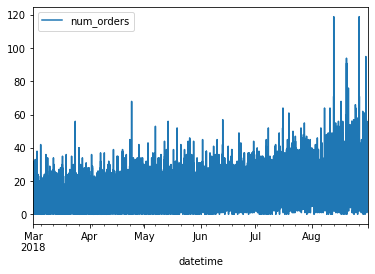

In [2]:
df = pd.read_csv('taxi.csv', parse_dates = [0], index_col = [0])
df.sort_index(inplace = True)
display(df.head())
df.info()
df.plot();

Пропусков нет. Данные представлены за каждые 10 минут начиная от 1 марта 2018 года 00:00:00 и до 31 августа 2018 23:50:00.

Выполним ресемлирование данных по одному часу. Создадим функцию, которая будет создавать в датасете новые признаки, с которыми в дальнейшем мы и будем работать и на которых будем проводить обучение моделей.

In [3]:
df = df.resample('1H').sum()

# Создадим функцию для добавления новых признаков
def make_features(data, max_lag, rolling_mean_size):
    # Добавим новый DataFrame, который будет являться копией исходного
    auxillary_df = data.copy()
    auxillary_df['month'] = data.index.month
    auxillary_df['day'] = data.index.day
    auxillary_df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        auxillary_df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    auxillary_df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return auxillary_df

На этом подготовку данных можем считать завершённой.

# 2. Анализ данных

Проведём декомпозицию на тренд и сезонность. При изучении сезонности с ресемплированием по часам не обязательно рассматривать данные за большой промежуток времени.

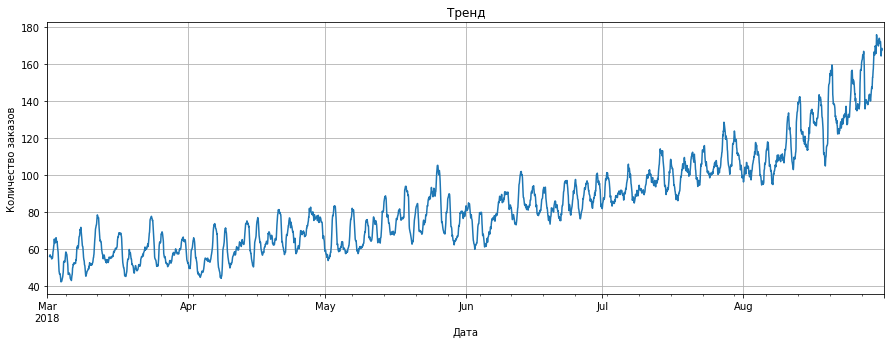

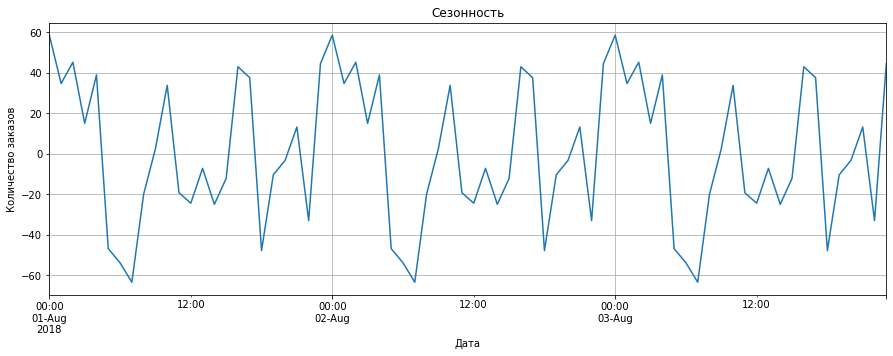

In [4]:
decomposed = seasonal_decompose(df.resample("1H").sum())
decomposed.trend.plot(title = "Тренд", grid = True,
                      figsize = (15, 5), xlabel = "Дата",
                      ylabel = "Количество заказов")
plt.show()
seasonal_decompose(df["2018-08-01" : "2018-08-03"].resample("1H").sum()).seasonal.plot(grid = True, figsize = (15, 5), \
title = "Сезонность", xlabel = "Дата", ylabel = "Количество заказов")
plt.show()

Линия тренда говорит об общем увеличении увеличении заказов. На графике, отражающем сезонность, можно увидеть, что обычно количество заказов возрастает ночью и вечером. Утром обычно немного заказов.

# 3. Обучение

Перейдём к этапу обучения. Здесь будет необходимо:
1. Добавить признаки к исходному датасету (их количество можно будет проварьировать)
2. Разбить все данные на обучающую и тестовую выборку с требуемым соотношением датасетов
3. Отмасштабировать данные
4. Обучить модели линейной регрессии

In [5]:
# Добавляем признаки
featured_df = make_features(df, 200, 10)

# Проводим разбиение на обучающую и тестовую выборки
train, test = train_test_split(featured_df, shuffle = False, test_size = 0.1)
train.dropna(inplace = True)

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

# Проводим масштабирование данных
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(features_train_scaled, target_train);

<ipython-input-5-8c6d50a16bf6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace = True)


# 4. Тестирование

Проведём тестирование модели. Для этого получим предсказания модели. Посчитаем RMSE нашей модели.

Сравним значение RMSE нашей модели с RMSE модели, выдающей медианное значение.

In [6]:
preds = model.predict(features_test_scaled)
rmse = mse(target_test, preds) ** 0.5
print('RMSE линейной регрессии:', rmse.round(5))

# Для тестовой выборки требуемый RMSE = 48. Оценим, насколько наши предсказания лучше (или хуже) требуемых
RMSE_REQ = 48
rmse_ratio = rmse / RMSE_REQ
print('\nОтношение полученного RMSE к требуемому:', rmse_ratio.round(5), '\n')

# Теперь проверим качество модели, выдающей медианное значение как предсказание
preds_median = np.ones(test.shape[0]) * train['num_orders'].median()
dummy_rmse = mse(target_test, preds_median) ** 0.5
print("RMSE dummy-модели:", dummy_rmse.round(5))

RMSE линейной регрессии: 35.56112

Отношение полученного RMSE к требуемому: 0.74086 

RMSE dummy-модели: 86.41466


Теперь изучим, какие предсказания дадут нам модели DecisionTreeRegressor и RandomForestRegressor. Проведём перебор параметров. Выберем лучшие результаты и отразим их.

In [7]:
# Добавим валидационную выборку, на которой определим лучшую модель
train_aux, valid = train_test_split(train, shuffle = False, test_size = 0.25)

features_train_aux = train_aux.drop(['num_orders'], axis = 1)
target_train_aux = train_aux['num_orders']

features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

# Начнём обучение моделей и проверку качества предсказаний на валидационной выборке
best_dtr_rmse = 100
best_rfr_rmse = 100
count_dtr = 0
count_rfr = 0

for depth in range(1, 16):
    dtr_model = DecisionTreeRegressor(max_depth = depth)
    rfr_model = RandomForestRegressor(n_estimators = 80, max_depth = depth)

    dtr_model.fit(features_train_aux, target_train_aux)
    rfr_model.fit(features_train_aux, target_train_aux)

    preds_dtr = dtr_model.predict(features_valid)
    preds_rfr = rfr_model.predict(features_valid)
    
    rmse_dtr = mse(target_valid, preds_dtr) ** 0.5
    rmse_rfr = mse(target_valid, preds_rfr) ** 0.5
    
    if rmse_dtr < best_dtr_rmse:
        best_dtr_rmse = rmse_dtr
        count_dtr = depth
        
    if rmse_rfr < best_rfr_rmse:
        best_rfr_rmse = rmse_rfr
        count_rfr = depth
        
print('Лучший результат для DTR при depth =', count_dtr)
print('Лучший результат для RFR при depth =', count_rfr)
print('Лучшее значение RMSE для DTR =', best_dtr_rmse)
print('Лучшее значение RMSE для RFR =', best_rfr_rmse)

Лучший результат для DTR при depth = 4
Лучший результат для RFR при depth = 9
Лучшее значение RMSE для DTR = 30.424361461016602
Лучшее значение RMSE для RFR = 27.746399071303838


In [8]:
# Обучаем лучшую из получившихся моделей
model_dtr = DecisionTreeRegressor(max_depth = count_dtr)
model_rfr = RandomForestRegressor(n_estimators = 80, max_depth = count_rfr)

dtr_model.fit(features_train, target_train)
rfr_model.fit(features_train, target_train)

preds_dtr = dtr_model.predict(features_test)
preds_rfr = rfr_model.predict(features_test)

rmse_dtr = mse(target_test, preds_dtr) ** 0.5
rmse_rfr = mse(target_test, preds_rfr) ** 0.5

print('Лучшее значение RMSE для модели DecisionTreeRegressor:', rmse_dtr)
print('Лучшее значение RMSE для модели RandomForestRegressor:', rmse_rfr)

Лучшее значение RMSE для модели DecisionTreeRegressor: 59.07802106517854
Лучшее значение RMSE для модели RandomForestRegressor: 39.31835555094902


In [9]:
print("RMSE dummy-модели:", dummy_rmse.round(5))

RMSE dummy-модели: 86.41466


# Вывод

Получили, что при тестировании моделей на валидационной выборке результаты оказались неплохими. Но на тестовой выборке они оказались гораздо хуже. Модели DecisionTreeRegressor и RandomForestRegressor выдают примерно одинаково плохие результаты по сравнению с моделью линейной регрессии.